### First exploration about data
- Importance of event: Click > Impression > Event

##### Read data
- Drop duplicates
- Remove "Event" data point, as it means that the users were not interested in the results.
- Remove wrong product names (such as #NAME? and #ERROR)

In [17]:
import pandas as pd
import jieba
import re
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
import jieba.posseg as pseg
import multiprocessing

# set matplotlib font to chinese
import matplotlib.font_manager as mfm
font_path = "../simhei.ttf"
prop = mfm.FontProperties(fname=font_path)

%matplotlib inline

product_log = pd.read_csv("../data.csv",sep="\t",names=["product_name", "category", "query", "event", "date"])

print product_log.shape, product_log.drop_duplicates().shape
product_log = product_log.drop_duplicates()
product_log = product_log[product_log.event!= "Event"]
product_log = product_log[(product_log.product_name!="#NAME?") & (product_log.product_name!="#ERROR!")]
product_log.head(5)

(10317, 5) (10310, 5)


,product_name,category,query,event,date
0,--- X 10 --- 七色 多層次搭配 圓下擺 LAYERED 素面 無袖背心 打底,Male Fashion,無袖,Impression,31/7/17
1,︱IBIT︱Gymshark 熱銷款 運動T恤 健身T恤 圓領短T 運動短T 健身鯊魚,Male Fashion,gymshark,Impression,31/7/17
2,︱IBIT︱Gymshark 超高彈性 短褲 運動短褲 跑步短褲 深蹲褲 訓練短褲,Male Fashion,gymshark,Impression,31/7/17
3,::另類情侶兄弟姊妹殼::電力滿格/不足黑白趣味浮雕手機軟殼i5/i5s/i5se/i6/i...,Mobile & Gadgets,軟殼,Click,31/7/17
4,：新舊手機商場：Iphone6 16金 （需要看細圖密我）,Mobile & Gadgets,iphone6 系列,Impression,30/7/17


In [9]:
# preprocessing
def preprocess(string):
    """
    preprocess the string to remove punctuations
    
    Inputs:
        @string: a text string
        
    Outputs:
        A cleaned string
    """
    string = re.sub(r"[\^&%$#@><+\-*.,!?;:/~\(\)]+","",string.lower())
    return string

In [10]:
product_log["query"] = product_log["query"].map(preprocess)
product_log.product_name = product_log.product_name.map(preprocess)

### Analyze how the search system work
- Exact match vs semantic match?
- Conclusion: close to exact match

In [11]:
def exact_match((title,query)):
    """
    Check if the search engine returns only exact match results
    
    Inputs:
        @title: product name of the record
        @query: the user query
    
    Output:
        A boolean value. True means exact match, False means non-exact-match
    """
    if (query in title) or (query in title.lower()):
        return True
    return False

product_log["exact_match"] = map(exact_match,zip(product_log.product_name, product_log['query']))

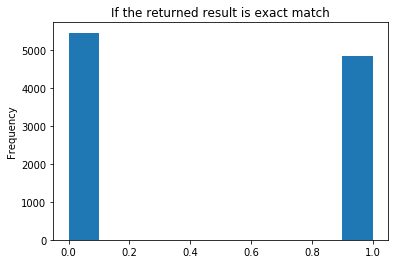

In [12]:
product_log.exact_match.plot(kind="hist")
plt.title("If the returned result is exact match")

### Study frequency of words

In [25]:
# preprocessing
def tokenize(string,allow_pos_tags = ['ns', 'n', 'vn', 'v','eng']):
    """
    Tokenize a given string with a set of allowed POS tags
    
    Inputs:
        @string: a text string
        @allow_pos_tags: a list of allowed POS tags. Default is ['ns', 'n', 'vn', 'v','eng']
        
    Return:
        @A generator of tokens
    """
    words = pseg.cut(string)
    for r in words:
        if r.flag in allow_pos_tags:
            yield(r.word)

In [28]:
%time titles = product_log.product_name.map(lambda x: list(tokenize(x)))
%time keywords = product_log['query'].map(lambda x: list(tokenize(x)))

CPU times: user 12min 11s, sys: 1.94 s, total: 12min 12s
Wall time: 12min 14s
CPU times: user 1min 22s, sys: 118 ms, total: 1min 22s
Wall time: 1min 22s


In [16]:
## show how the tokenizer work
print product_log.product_name.iloc[1]
words = pseg.cut(product_log.product_name.iloc[1])
for r in words:
    print "Word: ", r.word, "POS Tag: ",r.flag

︱ibit︱gymshark 熱銷款 運動t恤 健身t恤 圓領短t 運動短t 健身鯊魚
Word:  ︱ POS Tag:  x
Word:  ibit POS Tag:  eng
Word:  ︱ POS Tag:  x
Word:  gymshark POS Tag:  eng
Word:    POS Tag:  x
Word:  熱銷款 POS Tag:  n
Word:    POS Tag:  x
Word:  運動 POS Tag:  vn
Word:  t POS Tag:  eng
Word:  恤 POS Tag:  n
Word:    POS Tag:  x
Word:  健身 POS Tag:  v
Word:  t POS Tag:  eng
Word:  恤 POS Tag:  n
Word:    POS Tag:  x
Word:  圓領 POS Tag:  n
Word:  短 POS Tag:  b
Word:  t POS Tag:  eng
Word:    POS Tag:  x
Word:  運動 POS Tag:  vn
Word:  短 POS Tag:  b
Word:  t POS Tag:  eng
Word:    POS Tag:  x
Word:  健身 POS Tag:  v
Word:  鯊魚 POS Tag:  n


In [29]:
product_log["query_tokens"] = keywords
product_log["title_tokens"] = titles

In [30]:
from collections import Counter
Counter(product_log.event)

Counter({'Click': 2297, 'Impression': 7999})

In [31]:
# frequency count of tokens
import operator
corpus = titles + keywords
corpus = [w for sentence in corpus for w in sentence]
vocab = Counter(corpus)
vocab = sorted(vocab.items(), key=operator.itemgetter(1),reverse=True)

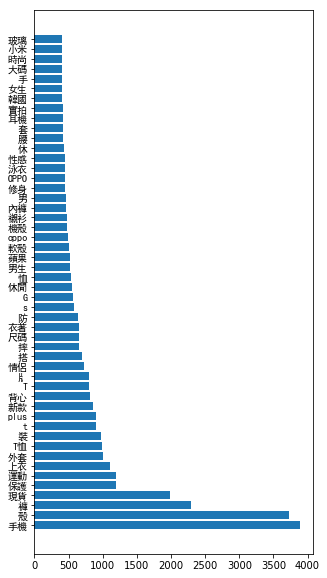

In [32]:
# word frequency plot
plt.figure(figsize=(5,10))
n = 50
plt.barh(np.arange(n),np.array(vocab[:n])[:,1])
_ = plt.yticks(np.arange(n), np.array(vocab[:n])[:,0],fontproperties=prop)

In [35]:
# save file
import cPickle
with open("data_preprocessed.pkl","w") as f:
    cPickle.dump(product_log,f)